In this notebook we build upon fermion_spin_hopping_qutip to try and build a QPC meassuring a single/double dot system. Here, we model the QPC as a thighbinding model with equal hopping everywhere except where its is hooked up to the double dot system via a quartic interaction. 

**This chain should be long enough that the wave packet does not bounce back before we see events in the double dot system**.

The double dot is isolated and we are also not considering dephasing anywhere. For this reason, **it may be better to use some Schrödinger equation solver rather than the full Lindbladian**. 


## What we could do here is write a cluster script that runs this like 100 times such that at each simulation we have an independent electron interacting with the double dot. We could then average over that 

In [1]:
import numpy as np
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
from qutip import  *
import os
import sys

# add path to project dir so we can include custom modules from src
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

sys.path.insert(0, parent_path)

from src.qutip_tools import *



In [2]:
def gen_gauss_init(l0, sigma, Nsites, k0=0):
    # creates a gaussian initial condition centerd on l0 with bandwidth sigma for Nsites
    # and initial velocity k0

    x = np.asarray(range(0,Nsites))
    coefs = ((np.sqrt(np.pi)*sigma)**(-0.5))*np.exp(-0.5*(x-l0)**2/(sigma)**2 )*np.exp(1j*k0*(x-l0))
    
    return coefs    

In [3]:
def get_qpc_H(op_list, Nsites, Nqpc,jcouple):
        # create the Hamiltonian for the QPC where Nsites includes the double dot
    # and Nqpc only has the qpc site
    ident_tensor = tensor([identity(2)]*(Nsites)) 
    H = 0*ident_tensor

    for site_j in range(0,Nqpc-1):
        H += -0.5*jcouple[site_j]*(op_list[site_j].dag()*op_list[site_j+1]+
                                   op_list[site_j+1].dag()*op_list[site_j])
    return H 
    

In [16]:
L_qpc = 13  # lenth of the QPC chain
L = L_qpc+2 # QPC times double dot 
max_t = 20 # maximum time
tsteps = 200 # number of time steps
bond_index = int(L_qpc/2) # shift the bond to the left from the center
gamma = 0.0
centered_at = 0 # initial QPC position of wavepacket
band_width = 0.4 # width of the gaussian wave packet
K0 = 0.01 # Initial velocity of the wavepacket
J_prime = 1.0 # contact to double dot
t = 0.8 # hopping between quantum dots 
Omega = 0.0 # coupling between dot 1 and QPC

# dot energies not yet implemented
E1 = 0.0
E2 = 0.0
epsilon = np.zeros(L_qpc) # energies of the QPC chains 

epsilon[:int(L_qpc/2)] = 0.0 # source energies
epsilon[int(L_qpc/2):] = 0.0 # drain energies
J = np.ones(L_qpc) # QPC hopping
# this means that I am putting the dangling bond between sites int(L_qpc/2) and int(L_qpc/2)+1
# where the interaction to the double dot is also located
J[int(L_qpc/2)] = J_prime  



In [5]:
# create the 1 particle basis and the coeficients for the initial state
str_list, basis_list = get_1p_basis(L_qpc)
# build the initial condition for the QPC
qpc_init = gen_gauss_init(centered_at, band_width, L_qpc, k0=K0)
psi_qpc = [qpc_init[j]*basis_list[j] for j in range(0,len(qpc_init))]

# create the dot basis
dot_basis = [tensor(basis(2,0),basis(2,1)), tensor(basis(2,1),basis(2,0))]
# build the initial condition for the dot
dot_init = [0.0, 0.1]
psi_dot = [dot_basis[j]*dot_init[j] for j in range(0,len(dot_basis))]

# assume dot initial state completely independent from QPC init state so we can factorize the probas
full_basis = []
# combine them 
for i in range(0,len(basis_list)):
    for j in range(0, len(dot_basis)):
        full_basis.append(tensor([psi_qpc[i], psi_dot[j]]))
      
# state correspond to particle in qpc all the way to the left and particle on left dot
psi0 = np.sum(full_basis)
psi0 = psi0.unit()   

# normalize       
rho = ket2dm(psi0) # initial density matrix
# create the fermion operator list
c_list = [fdestroy(L,i) for i in range(0,L)]

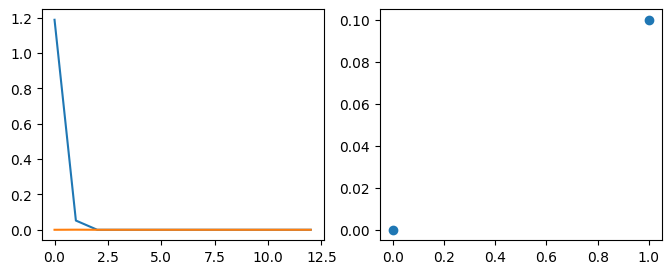

In [6]:
# visualize the initial conditions
fig, ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(range(0,L_qpc),qpc_init.real)
ax[0].plot(range(0,L_qpc),qpc_init.imag)

ax[1].scatter(range(0,2),dot_init)

In [7]:
# create the hamiltonian start with qpc
H_QC = get_qpc_H(c_list, L ,L_qpc,J)

# double dot H
Hdot = -t*(c_list[-1].dag()*c_list[-2] + c_list[-2].dag()*c_list[-1])

# interaction H
Hint =  Omega*c_list[-2].dag()*c_list[-2]*( c_list[int(L_qpc/2)].dag()*c_list[int(L_qpc/2)+1] +
                                          c_list[int(L_qpc/2)+1].dag()*c_list[int(L_qpc/2)] )

H = H_QC + Hdot  + Hint

print(H_QC.isherm, Hdot.isherm, Hint.isherm, H.isherm)

# get the operators needed for lindbladian 
# hrtr we don't really want dephasing but just put it there for now
collapse_ops, expect_ops = create_lindblad_op(L, c_list, gamma)
# add the energy to also track it
expect_ops.append(H)

# for plotting SMALL Hamiltonians
"""fig, ax = hinton(H)
ax.tick_params(axis='both', which='major', labelsize = 7)
ax.tick_params(axis='x', rotation=90)
plt.savefig('H.pdf')"""


True True True True


"fig, ax = hinton(H)\nax.tick_params(axis='both', which='major', labelsize = 7)\nax.tick_params(axis='x', rotation=90)\nplt.savefig('H.pdf')"

In [8]:
times = np.linspace(0.0, max_t, tsteps)
# result = mesolve(H, rho, times, e_ops=expect_ops)

result = sesolve(H, psi0, times, e_ops=expect_ops)

result

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0001659393310546875
    preparation time: 0.02234792709350586
    run time: 1.6110560894012451
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 20.0] (200 steps)
  Number of e_ops: 16
  State not saved.
>

## Densities

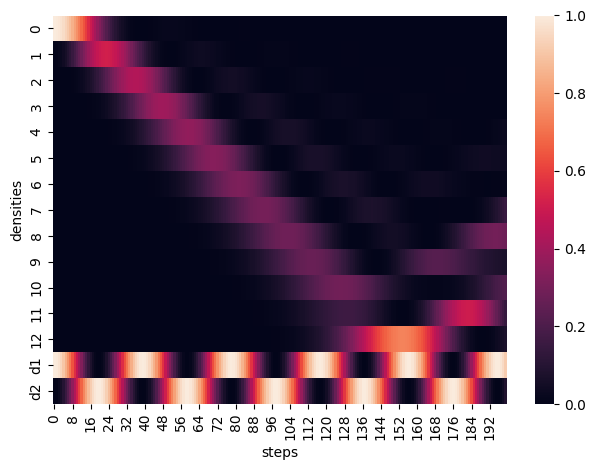

In [9]:
plt.plot()

xt = np.linspace(0,max_t,5)
# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(result.expect[:-1])
ax.set_xlabel("steps")
ax.set_ylabel("densities")

site_ticks = list(range(0,L_qpc)) + ["d1","d2"]
tick_pos = np.asarray(range(0,L)) + 0.5

ax.set_yticks(tick_pos,site_ticks);

plt.tight_layout()

#plt.savefig("../plots/QPC_double_dot/heatmap_Om={:.2f}_L={:.2f}_tdot={:.2f}_Jp={:.2f}.png".format(Omega,
#                                                    L_qpc, t, J_prime), dpi=400)


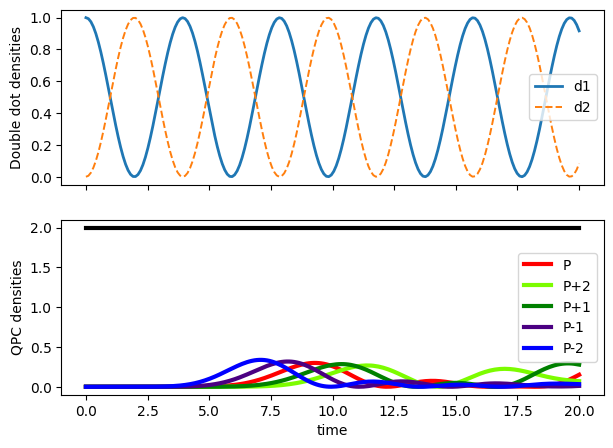

In [10]:
fig, ax = plt.subplots(2,1, figsize=(7,5),sharex=True)

# in dot
ax[0].plot(times, result.expect[-3], linewidth=2, alpha=1.0, label="d1")
ax[0].plot(times, result.expect[-2], linewidth=1.4, alpha=1.0, linestyle="dashed" ,label="d2")

# in Qpc
#for i in range(0,L_qpc):
#    ax[1].plot(times, result.expect[i], linewidth=2, alpha=0.7)
    
ax[1].plot(times, result.expect[int(L/2)], linewidth=3,c="red", label="P")
ax[1].plot(times, result.expect[int(L/2)+2], linewidth=3, c="lawngreen",label="P+2")
ax[1].plot(times, result.expect[int(L/2)+1], linewidth=3, c="green",label="P+1")
ax[1].plot(times, result.expect[int(L/2)-1], linewidth=3, c="indigo", label="P-1")
ax[1].plot(times, result.expect[int(L/2)-2], linewidth=3, c="blue", label="P-2")


# get the total particle number
# get the sum of the local densities
n_tot = np.sum(result.expect[:-1], axis=0)
ax[1].plot(times, n_tot, c='black', linewidth=3.0)

ax[1].set_xlabel("time")
ax[0].set_ylabel("Double dot densities")
ax[1].set_ylabel("QPC densities")
ax[0].legend()
ax[1].legend()

#plt.savefig("../plots/QPC_double_dot/densities_Om={:.2f}_L={:.2f}_tdot={:.2f}_Jp={:.2f}.pdf".format(Omega,
#                                                    L_qpc, t, J_prime))


## Oscillation frequency in the dots

Here we compare with the rabi frequency of an isolated dot $\omega_r= \frac{t}{\hbar}$ by taking the fourier rtansform of the dot occupations.
THe probability of occupation is 

$P_1(t) = t sin^2 (\omega t)$ 

**But I don't think this is as straightforward to do with the occupations**

Text(0.5, 0, '$\\omega$')

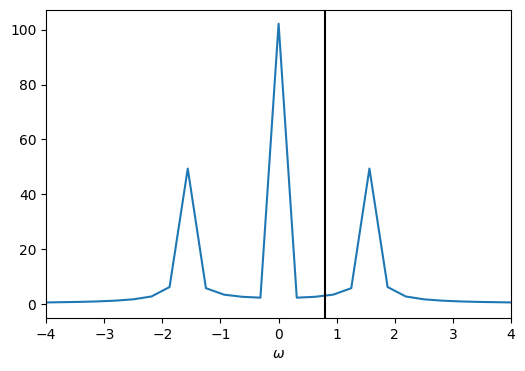

In [15]:
omega_r = t # set hbar to 1
dt = times[2]-times[1]
# n2_ft = fft(np.sin(omega_r*times)) # for debugging  
n2_ft = fft(result.expect[-3])
# put frequency in the correct units
freqs = (2*np.pi)*fftfreq(len(times),dt)

# now shift so we can display properly
n2_ft = fftshift(n2_ft)
freqs = fftshift(freqs)

fig, ax = plt.subplots(1,1, figsize=(6,4))
plt.plot(freqs, abs(n2_ft))
ax.axvline(omega_r, c='black')
ax.set_xlim(-4,4)
ax.set_xlabel("$\omega$")

## Reflection and Transmision

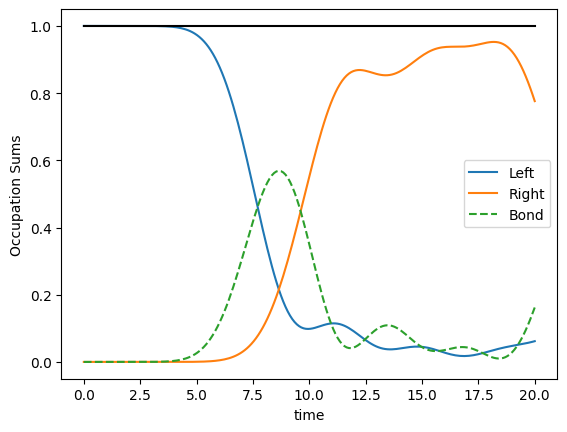

In [12]:
# exclude the sites at Lp/2 and Lp/2 +1 where the bond is located
n_left = np.sum(result.expect[:int(L_qpc/2)], axis=0)
# the minus 3 is because we  leave out the energy and dot occupations
n_right = np.sum(result.expect[int(L_qpc/2)+2:-3], axis=0)
# occupation in the bond
n_bond = result.expect[int(L_qpc/2)] + result.expect[int(L_qpc/2)+1] 

plt.plot(times, n_left, label="Left")
plt.plot(times,n_right,label="Right")
plt.plot(times,n_bond,label="Bond", linestyle="dashed")

plt.plot(times,n_left+n_right+n_bond, c = 'black')
plt.xlabel("time")
plt.ylabel("Occupation Sums")

plt.legend()

Text(0, 0.5, 'Energy')

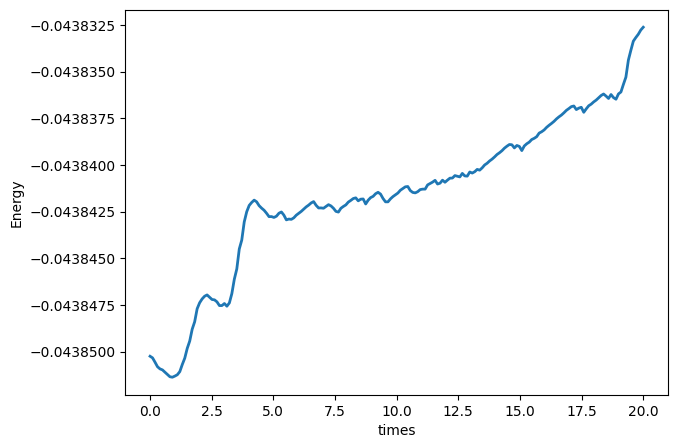

In [13]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(times, result.expect[-1], linewidth=2.0)

ax.set_xlabel("times")
ax.set_ylabel("Energy")
